# Electric Motor Temperature

## Introduction

The aim of this project is to predict the **permanent magnet temperature**  of a permanent magnet synchronous motor (PMSM) using simple linear regression models. The PMSM represents a German OEM's prototype model and the variables provided have been collected on a test bench. As suggested in the explanatory notes of the dataset, sensor measuring all the different temperatures of the motor and the "torque" are not reliable nor economically feasible in commercial applications. A sufficiently accurate prediction model would therefore eliminate the need for sensor measurements to determine the permanent magnet temperature. Other methods have been used in Engineering to predict the temperature although classic thermal modelling requires expertise in Thermodynamics. 
Temperature control of the elements of the motor are important as high temperatures in the permanent magnet could demagnetize it damaging the motor.

## Data Description 

The data has been downloaded from a dataset in Kaggle provided by Paderborn University (Germany).

https://www.kaggle.com/wkirgsn/electric-motor-temperature

The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". All recordings are sampled at 2 Hz.

Columns: 

- ambient  :    Ambient temperature as measured by a thermal sensor located closely to the stator.      
- coolant  :    Coolant temperature. The motor is water cooled. Measurement is taken at outflow.     
- u_d      :    Voltage d-component 
- u_q      :    Voltage q-component
- motor_speed : Motor speed    
- torque    :   Torque induced by current  
- i_d       :   Current d-component 
- i_q       :   Current q-component     
- pm        :   Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared
- stator_yoke  : Stator yoke temperature measured with a thermal sensor.
- stator_winding : Stator tooth temperature measured with a thermal sensor. 
- profile_id :  Each measurement session has a unique ID.






# Import libraries and load data

In [1]:

import warnings
warnings.filterwarnings('ignore')
import matplotlib
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error




In [2]:
df = pd.read_csv("pmsm_temperature_data.csv")# Load data set

# Exploring and understanding data

In [3]:
df.head()

ambient   coolant       u_d       u_q  motor_speed    torque       i_d  \
0 -0.752143 -1.118446  0.327935 -1.297858    -1.222428 -0.250182  1.029572   
1 -0.771263 -1.117021  0.329665 -1.297686    -1.222429 -0.249133  1.029509   
2 -0.782892 -1.116681  0.332771 -1.301822    -1.222428 -0.249431  1.029448   
3 -0.780935 -1.116764  0.333700 -1.301852    -1.222430 -0.248636  1.032845   
4 -0.774043 -1.116775  0.335206 -1.303118    -1.222429 -0.248701  1.031807   

        i_q        pm  stator_yoke  stator_tooth  stator_winding  profile_id  
0 -0.245860 -2.522071    -1.831422     -2.066143       -2.018033           4  
1 -0.245832 -2.522418    -1.830969     -2.064859       -2.017631           4  
2 -0.245818 -2.522673    -1.830400     -2.064073       -2.017343           4  
3 -0.246955 -2.521639    -1.830333     -2.063137       -2.017632           4  
4 -0.246610 -2.521900    -1.830498     -2.062795       -2.018145           4

In [4]:
df.shape 

(998070, 13)

 Dataset has nearly 100,000 data readings of 12 different electrical, thermodynamic and mechanical variables. The profile_id column represents the identification number for the recorded continuos session. The recording sessions vary in lenth of time. More explanation later when we plot the lenth of those sessions

In [5]:
df.info() # All data is numerical representing a sensor measurements

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


In [6]:
df.describe() # All measurements have been normalized and not represent real magnitudes 

ambient        coolant            u_d            u_q  \
count  998070.000000  998070.000000  998070.000000  998070.000000   
mean       -0.003905       0.004723       0.004780      -0.005690   
std         0.993127       1.002423       0.997878       1.002330   
min        -8.573954      -1.429349      -1.655373      -1.861463   
25%        -0.599385      -1.037925      -0.826359      -0.927390   
50%         0.266157      -0.177187       0.267542      -0.099818   
75%         0.686675       0.650709       0.358491       0.852625   
max         2.967117       2.649032       2.274734       1.793498   

         motor_speed         torque            i_d            i_q  \
count  998070.000000  998070.000000  998070.000000  998070.000000   
mean       -0.006336      -0.003333       0.006043      -0.003194   
std         1.001229       0.997907       0.998994       0.997912   
min        -1.371529      -3.345953      -3.245874      -3.341639   
25%        -0.951892      -0.266917      -0.756296      -0.257269   
50%        -0.140246      -0.187246       0.213935      -0.190076   
75%         0.853584       0.547171       1.013975       0.499260   
max         2.024164       3.016971       1.060937       2.914185   

                  pm    stator_yoke   stator_tooth  stator_winding  \
count  998070.000000  998070.000000  998070.000000   998070.000000   
mean       -0.004396       0.000609      -0.002208       -0.003935   
std         0.995686       1.001049       0.999597        0.998343   
min        -2.631991      -1.834688      -2.066143       -2.019973   
25%        -0.672308      -0.747265      -0.761951       -0.725622   
50%         0.094367      -0.057226       0.005085        0.006536   
75%         0.680691       0.697344       0.772239        0.725660   
max         2.917456       2.449158       2.326668        2.653781   

          profile_id  
count  998070.000000  
mean       50.732001  
std        22.073125  
min         4.000000  
25%        32.000000  
50%        56.000000  
75%        68.000000  
max        81.000000

All measurements have been normalized and not represent real magnitudes.

In [7]:
df.isna().sum()# There is no missing values 

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
profile_id        0
dtype: int64

In [8]:
df.columns

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
       'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding',
       'profile_id'],
      dtype='object')

In [9]:
df['profile_id'].unique()

array([ 4,  6, 10, 11, 20, 27, 29, 30, 31, 32, 36, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       72])

In [10]:
len(df['profile_id'].unique()) # There are 52 recording sessions, 


52

In [11]:
df['profile_id'].value_counts()

20    43970
6     40387
65    40093
66    36475
27    35360
4     33423
58    33381
56    33122
53    32441
79    31153
44    26340
70    25676
62    25599
30    23862
80    23823
74    23760
68    23330
36    22608
76    22187
48    21982
29    21357
32    20959
81    17671
45    17141
42    16919
73    16785
41    16699
63    16667
31    15586
69    15349
72    15300
10    15255
71    14655
77    14621
60    14542
61    14515
57    14402
75    13471
67    11134
49    10815
50    10809
55    10806
54    10806
78     8444
43     8442
11     7886
59     7474
51     6260
64     6249
52     3725
46     2179
47     2175
Name: profile_id, dtype: int64

Each session has recorded sensor's measurements from 18 min (profile 47 : 2175 samples/(2 * 60)=18.125 to just over 6 hours (profile 20: 43970 samples/( 2 * 60)= 366.417 min => 6.107 hours ///// Each sample has been recorded at a frequency of  2 Hz.


## Recorded sessions lenths

In [12]:
grouped_df_id = df.groupby(['profile_id'])

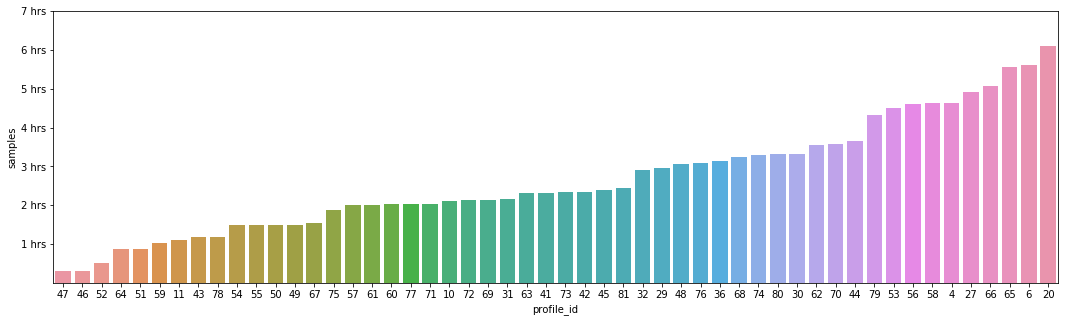

In [13]:
fig = plt.figure(figsize=(18, 5))
df_hours= grouped_df_id.size().sort_values().rename('samples').reset_index()
ordered_ids = df_hours.profile_id.values.tolist()
sns.barplot(y='samples', x='profile_id', data=df_hours, order = ordered_ids )
tcks = plt.yticks(2*3600*np.arange(1, 8), [f'{a} hrs' for a in range(1, 8)]) # 2Hz sample rate

This graph shows the different lenths of the recording sessions varying from 18 mins to more than 6 hours

## Linear Correlations

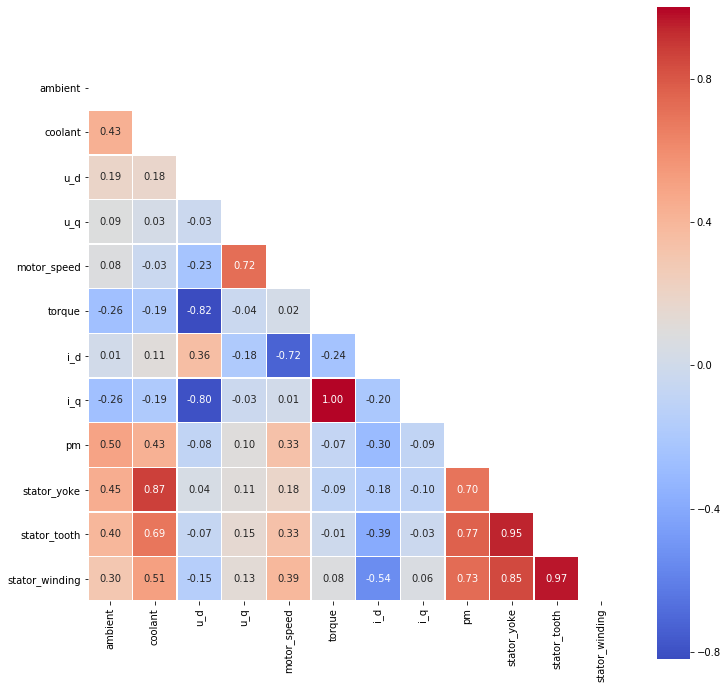

In [14]:
#correlation map of the dataframe excluding the profile_id
f,ax=plt.subplots(figsize=(12,12))
corr=df.drop('profile_id', axis = 1).corr() 
mask= np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', 
            mask= mask, 
            cmap= 'coolwarm',
            square=True,ax=ax)

plt.show()

All 4 temperatures inside the motor present multicollinearity  as expected. The same for  i_q and torque. We will plot later both on a particular recording session to check this relationship between i_q and torque
The 3 temperatures inside the motor will be removed from futher exploration as they are not measurable the same as 'pm' therefore we cannot use them as predictors. Torque cannot be used as a predictor either as is not measurable but we will be using it just for the visualitations and to gain some more understanding of the motor profile activity.

In [15]:
df_new = df.drop(['stator_yoke', 'stator_tooth', 'stator_winding','profile_id'], axis=1)# We drop the 3 temperatures which will not be used in our model as predictors.

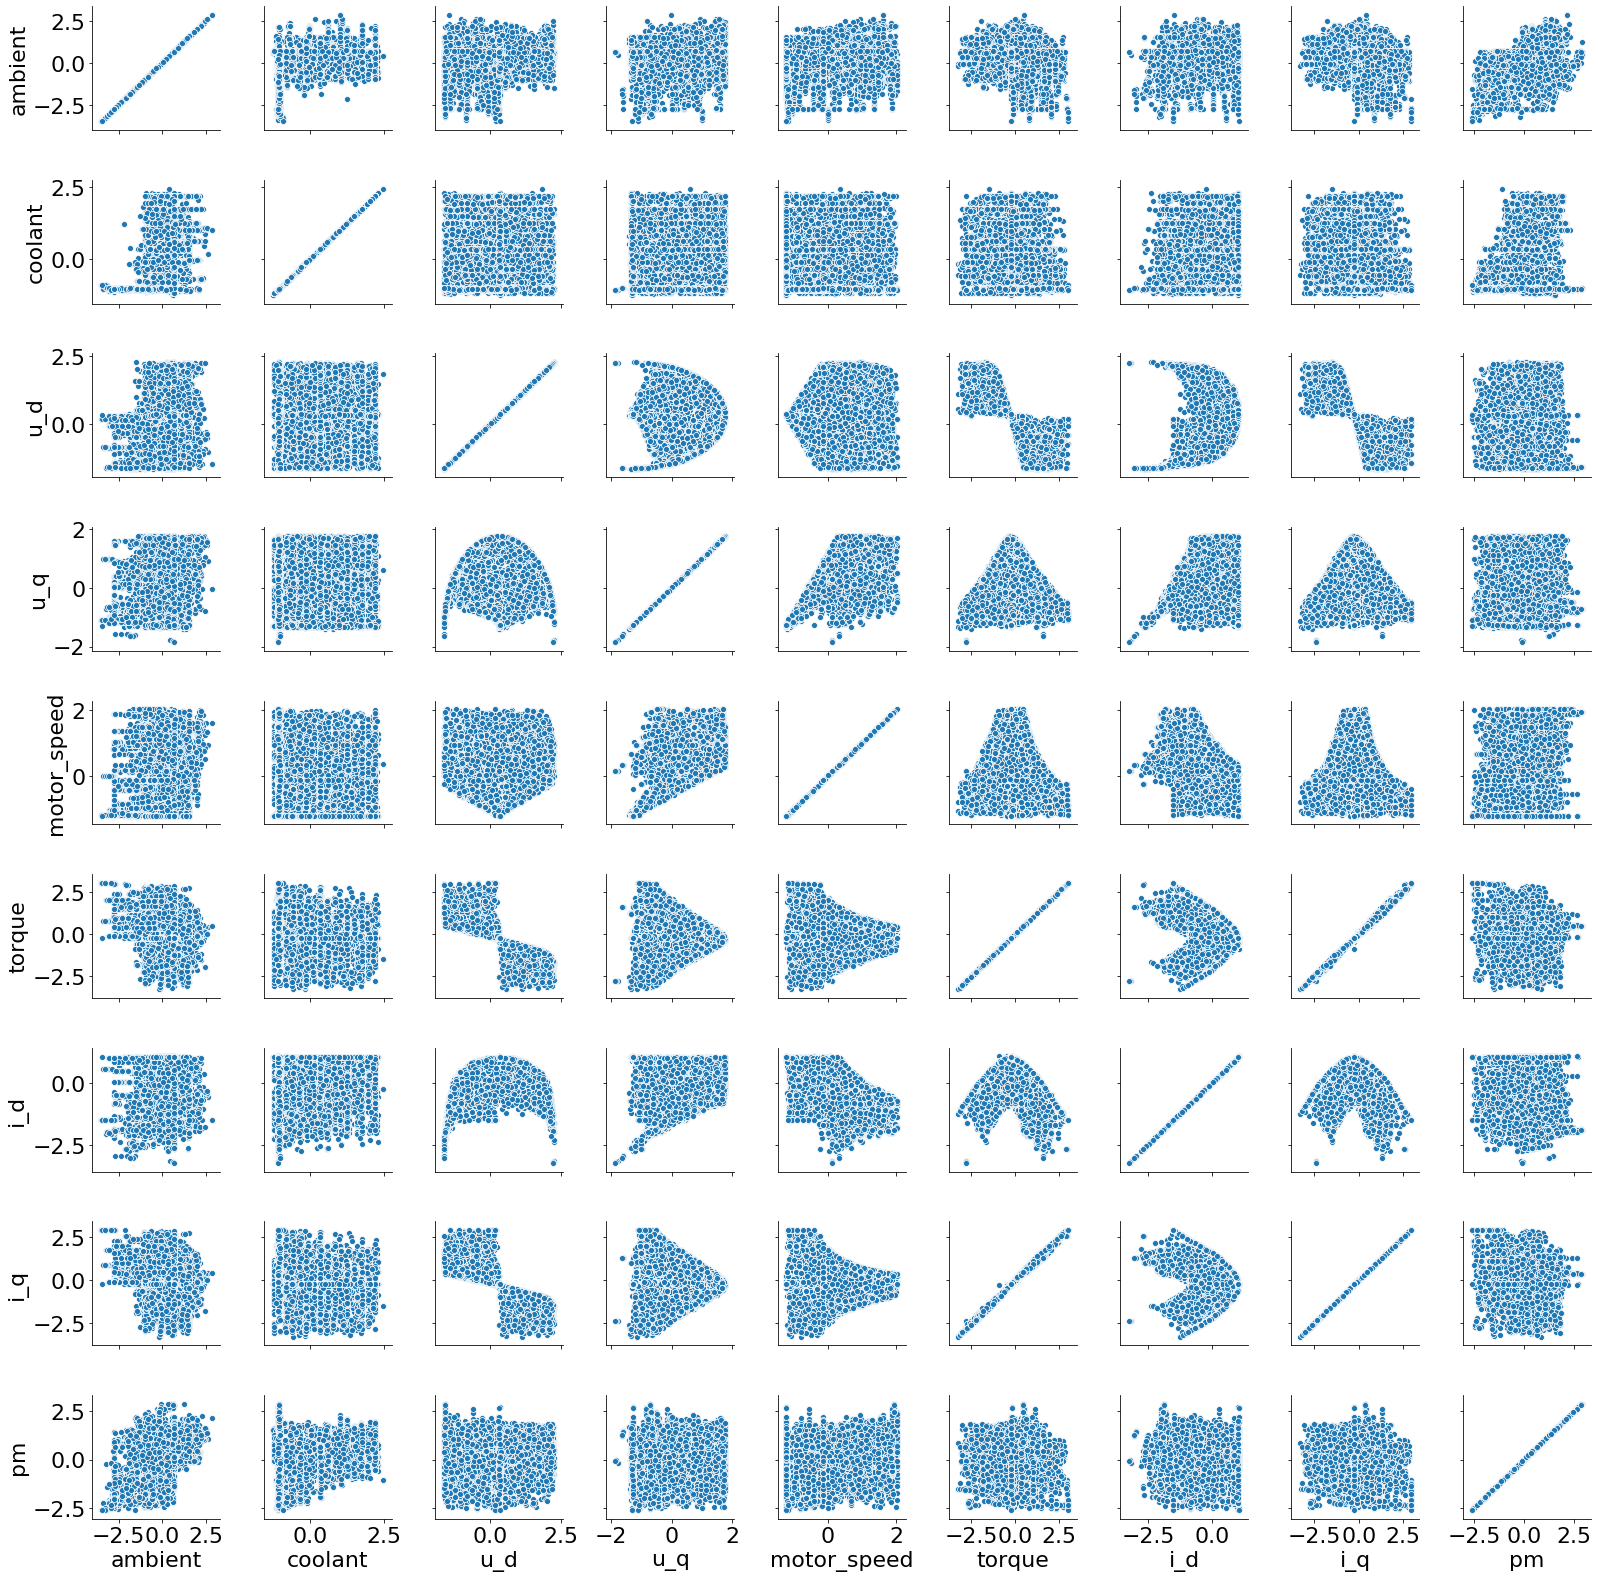

In [16]:
# Scatter plots the variables, only 10% sample of all datapoints

matplotlib.rcParams.update({'font.size': 22})
g = sns.PairGrid(df_new.sample(frac = 0.01))

g.map(sns.scatterplot)

There is a very clear linear positive correlation between torque and i_d as indicated previously by the correlation map

CPU times: user 2min 27s, sys: 2.82 s, total: 2min 30s
Wall time: 2min 30s


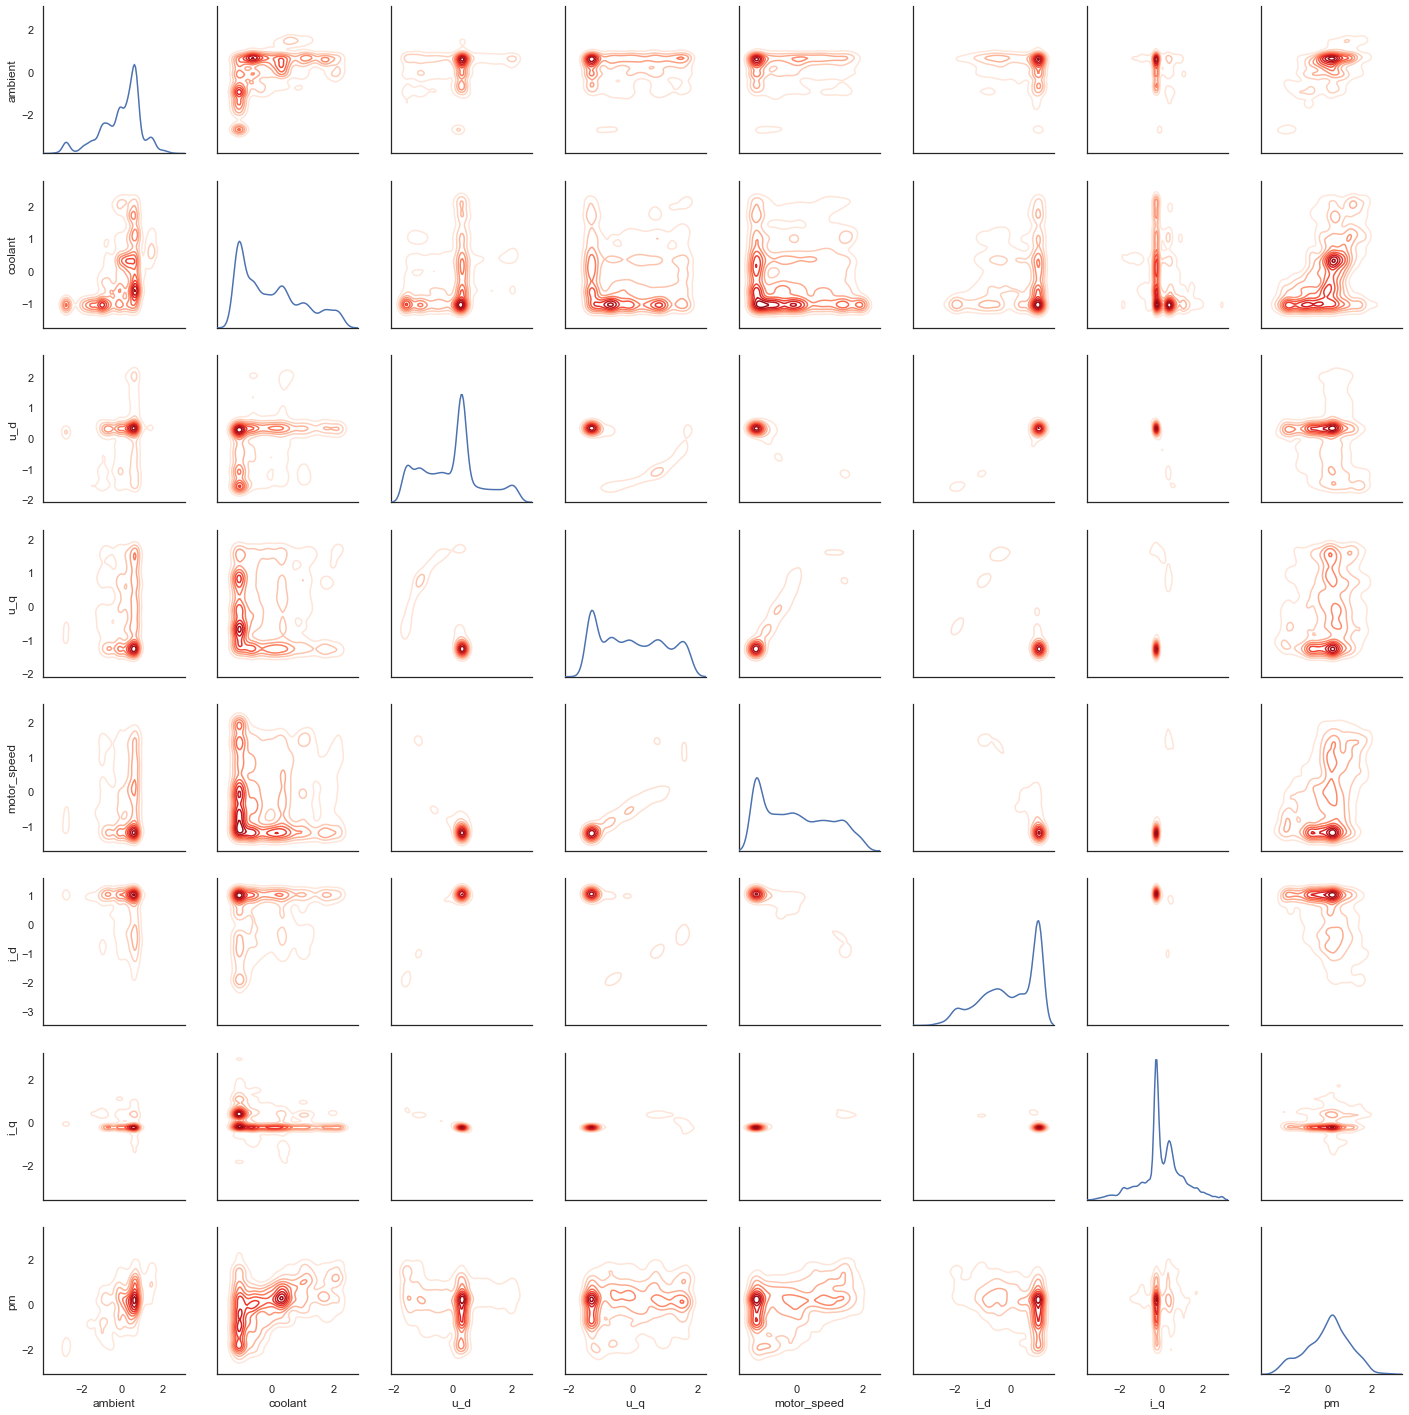

In [193]:

%%time
g = sns.PairGrid(df_new.sample(frac = 0.01))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot,n_level = 5, cmap="Reds")


In [17]:
grouped_df_id.head() 

ambient   coolant       u_d       u_q  motor_speed    torque  \
0      -0.752143 -1.118446  0.327935 -1.297858    -1.222428 -0.250182   
1      -0.771263 -1.117021  0.329665 -1.297686    -1.222429 -0.249133   
2      -0.782892 -1.116681  0.332771 -1.301822    -1.222428 -0.249431   
3      -0.780935 -1.116764  0.333700 -1.301852    -1.222430 -0.248636   
4      -0.774043 -1.116775  0.335206 -1.303118    -1.222429 -0.248701   
...          ...       ...       ...       ...          ...       ...   
982770 -0.626002 -0.528386  0.339220 -1.321197    -1.222418 -0.255637   
982771 -0.626477 -0.528384  0.311771 -1.263664    -1.207580 -0.021134   
982772 -0.627467 -0.528382  0.209214 -1.169932    -1.159165  0.544006   
982773 -0.629191 -0.528381  0.060589 -1.065101    -1.086407  1.016054   
982774 -0.632092 -0.528402 -0.116643 -0.949880    -0.995933  1.360879   

             i_d       i_q        pm  stator_yoke  stator_tooth  \
0       1.029572 -0.245860 -2.522071    -1.831422     -2.066143   
1       1.029509 -0.245832 -2.522418    -1.830969     -2.064859   
2       1.029448 -0.245818 -2.522673    -1.830400     -2.064073   
3       1.032845 -0.246955 -2.521639    -1.830333     -2.063137   
4       1.031807 -0.246610 -2.521900    -1.830498     -2.062795   
...          ...       ...       ...          ...           ...   
982770  1.029138 -0.245709 -1.630747    -1.188461     -1.450037   
982771  0.921595  0.017990 -1.630811    -1.185941     -1.449785   
982772  0.507795  0.591304 -1.630484    -1.184135     -1.450417   
982773  0.136077  1.061478 -1.642564    -1.182422     -1.450418   
982774 -0.137493  1.404434 -1.642682    -1.180167     -1.453757   

        stator_winding  profile_id  
0            -2.018033           4  
1            -2.017631           4  
2            -2.017343           4  
3            -2.017632           4  
4            -2.018145           4  
...                ...         ...  
982770       -1.505027          72  
982771       -1.504933          72  
982772       -1.504663          72  
982773       -1.504376          72  
982774       -1.504852          72  

[260 rows x 13 columns]

In [18]:

def get_df_profile(dfgpr,idpr): 
    """ Returns a dataframe for each id_number profile from the groupby dataframe 
        dfgpr = Groupby dataframe
        idpr =  id number for the profile recorded profile session
        """
    df_pr = dfgpr.get_group(idpr).reset_index()
    df_pr.drop(['index','profile_id'],inplace= True, axis=1)
    return df_pr


In [19]:
df72 = get_df_profile(grouped_df_id,72)
df72.head()

ambient   coolant       u_d       u_q  motor_speed    torque       i_d  \
0 -0.626002 -0.528386  0.339220 -1.321197    -1.222418 -0.255637  1.029138   
1 -0.626477 -0.528384  0.311771 -1.263664    -1.207580 -0.021134  0.921595   
2 -0.627467 -0.528382  0.209214 -1.169932    -1.159165  0.544006  0.507795   
3 -0.629191 -0.528381  0.060589 -1.065101    -1.086407  1.016054  0.136077   
4 -0.632092 -0.528402 -0.116643 -0.949880    -0.995933  1.360879 -0.137493   

        i_q        pm  stator_yoke  stator_tooth  stator_winding  
0 -0.245709 -1.630747    -1.188461     -1.450037       -1.505027  
1  0.017990 -1.630811    -1.185941     -1.449785       -1.504933  
2  0.591304 -1.630484    -1.184135     -1.450417       -1.504663  
3  1.061478 -1.642564    -1.182422     -1.450418       -1.504376  
4  1.404434 -1.642682    -1.180167     -1.453757       -1.504852

In [179]:
def plot_dfprofile(df_pr):
    
    """ Function to line plot the variables for each profile recording session separated in four different plots
        df_pr = Dataframe with each profile session
        
        Parameters
        dfgpr : Groupby Dataframe with all id_profiles
    
        
    """
    
    matplotlib.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows= 4,ncols = 1, figsize=(18,25))

    ax = axes [0]
    ax.plot(df_pr['pm'],color = 'blue',linewidth = 2.00,label ='pm' )
    ax.plot(df_pr['stator_yoke'],color= 'red',linewidth= 2.00 , label = 'stator_yoke')
    ax.plot(df_pr['stator_tooth'],color= 'green',linewidth= 2.00,label = 'stator_tooth')
    ax.plot(df_pr['stator_winding'],color= 'purple',linewidth= 2.00,label = 'stator_winding')
    ax.set_xticks(np.linspace(0,len(df_pr),5, dtype = int).tolist() )
    ax.set_xticklabels(np.linspace(0,len(df_pr)/(2*60),5, dtype = int).tolist())
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_xlabel("Time in minutes")

    ax = axes[1]
    ax.plot(df_pr['ambient'],color= 'blue',linewidth=2.00, label ='ambient' )
    ax.plot(df_pr['coolant'],color= 'red',linewidth=2.00, label ='coolant')
    ax.plot(df_pr['motor_speed'],color= 'green',linewidth=2.00,label = 'motor_speed')
    ax.set_xticks(np.linspace(0,len(df_pr),5, dtype = int).tolist() )
    ax.set_xticklabels(np.linspace(0,len(df_pr)/(2*60),5, dtype = int).tolist())
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))

    ax = axes[2]

    ax.plot(df_pr['u_d'],color= 'blue',linewidth=2.00, label ='u_d' )
    ax.plot(df_pr['u_q'],color= 'red',linewidth=2.00, label ='u_q')
    ax.plot(df_pr['i_d'],color= 'green',linewidth=2.00,label = 'i_d')
    ax.set_xticks(np.linspace(0,len(df_pr),5, dtype = int).tolist() )
    ax.set_xticklabels(np.linspace(0,len(df_pr)/(2*60),5, dtype = int).tolist())
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))

    ax = axes[3]
    ax.plot(df_pr['i_q'],color= 'red',linewidth=2.00,label = 'i_q')
    ax.plot(df_pr['torque'],color= 'blue',linewidth=2.00, label ='torque' )
    ax.set_xticks(np.linspace(0,len(df_pr),5, dtype = int).tolist() )
    ax.set_xticklabels(np.linspace(0,len(df_pr)/(2*60),5, dtype = int).tolist())
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_xlabel("Time in minutes")
    ax.set_xlim(auto = True)




Two interesting profiles worth plotting are the ones with extreme temperatures on 'pm',  min = -2.631991 and max = 2.917456 and another unusual is 'ambient' = -8.573954
    

In [21]:
df[df['pm'] == df['pm'].max()]

ambient   coolant       u_d       u_q  motor_speed    torque  \
172078  1.020117 -1.056674 -1.651761 -1.253946     0.245923  1.917285   

             i_d       i_q        pm  stator_yoke  stator_tooth  \
172078 -2.601532  1.577004  2.917456     0.303545      1.296041   

        stator_winding  profile_id  
172078        1.740307          27

In [22]:
df[df['pm'] == df['pm'].min()]


ambient   coolant       u_d       u_q  motor_speed    torque  \
237100 -3.211671 -0.955446  0.347322 -1.283859    -1.222434 -0.247703   

             i_d      i_q        pm  stator_yoke  stator_tooth  \
237100  1.029235 -0.24574 -2.631991    -1.783079     -2.038974   

        stator_winding  profile_id  
237100       -1.983555          32

In [23]:
df[df['ambient'] == df['ambient'].min()]

ambient   coolant       u_d       u_q  motor_speed    torque  \
347394 -8.573954 -1.429349 -1.190418  0.682727     0.130297  0.998207   

             i_d      i_q        pm  stator_yoke  stator_tooth  \
347394 -0.107606  1.03944 -0.620771    -0.532281     -0.453628   

        stator_winding  profile_id  
347394        -0.47793          44

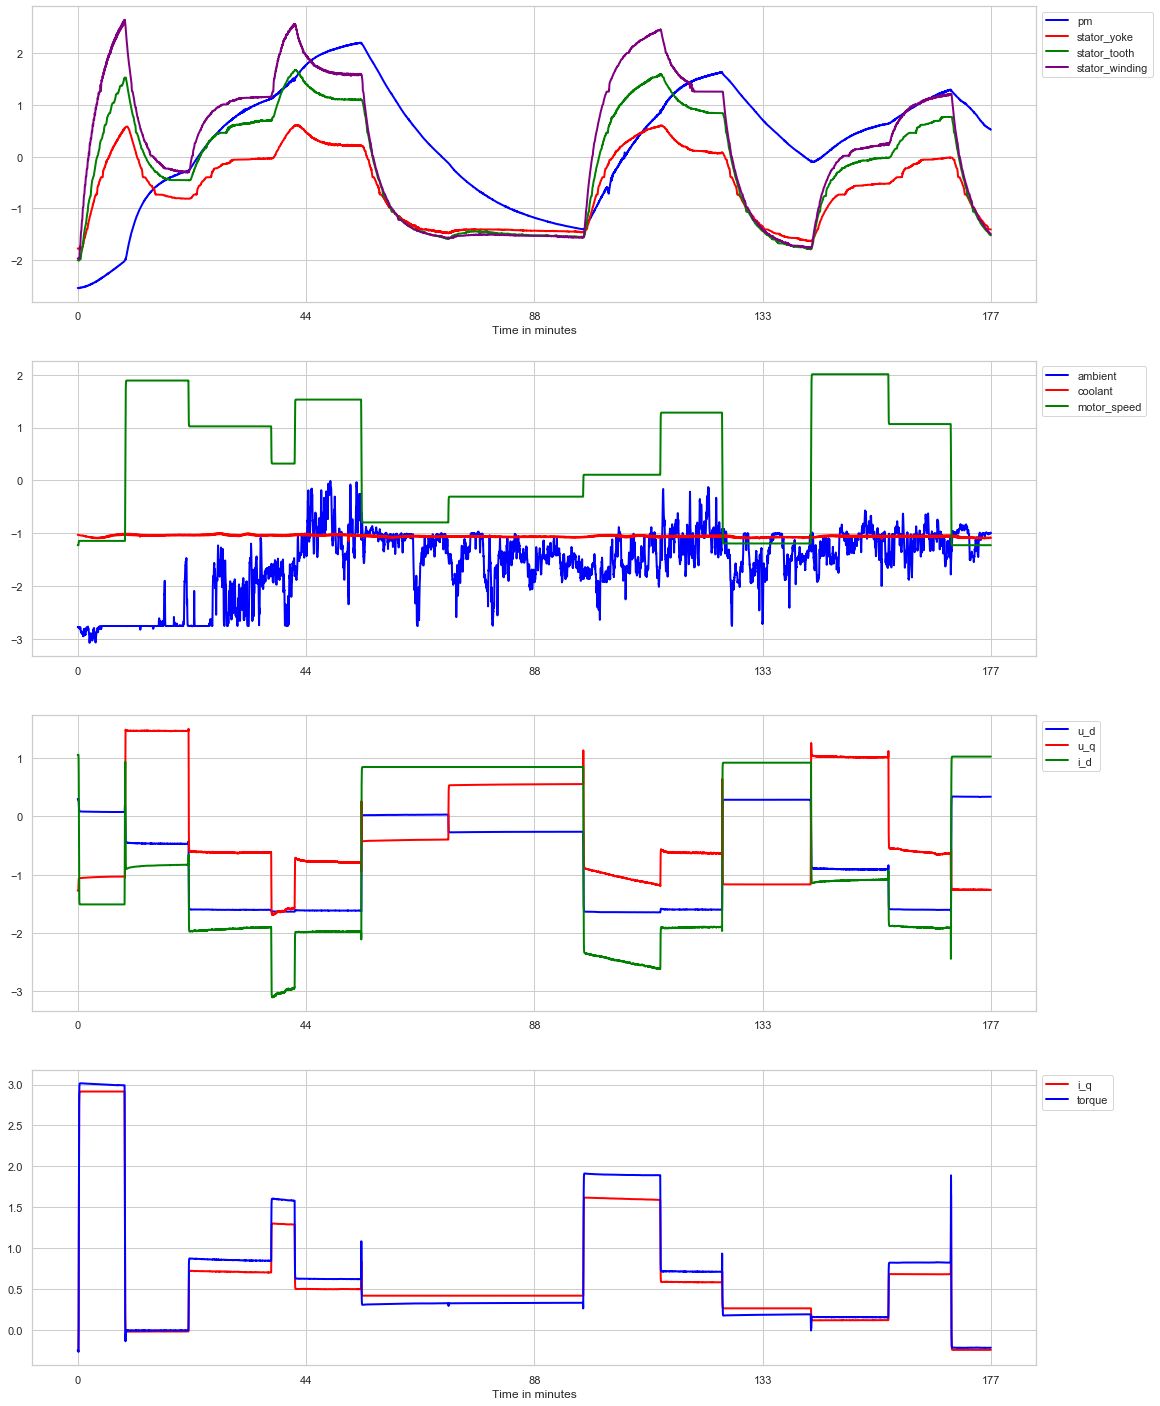

In [185]:

# Changing the id_session number we can plot any recording session.
# The top plot shows the different motor temperatures in close proximity.

id_session = 29
plot_dfprofile(get_df_profile(grouped_df_id,id_session))


At the last plot we can see the close relationship between torque and 'i_d' the current in the stator, following the same pattern. 

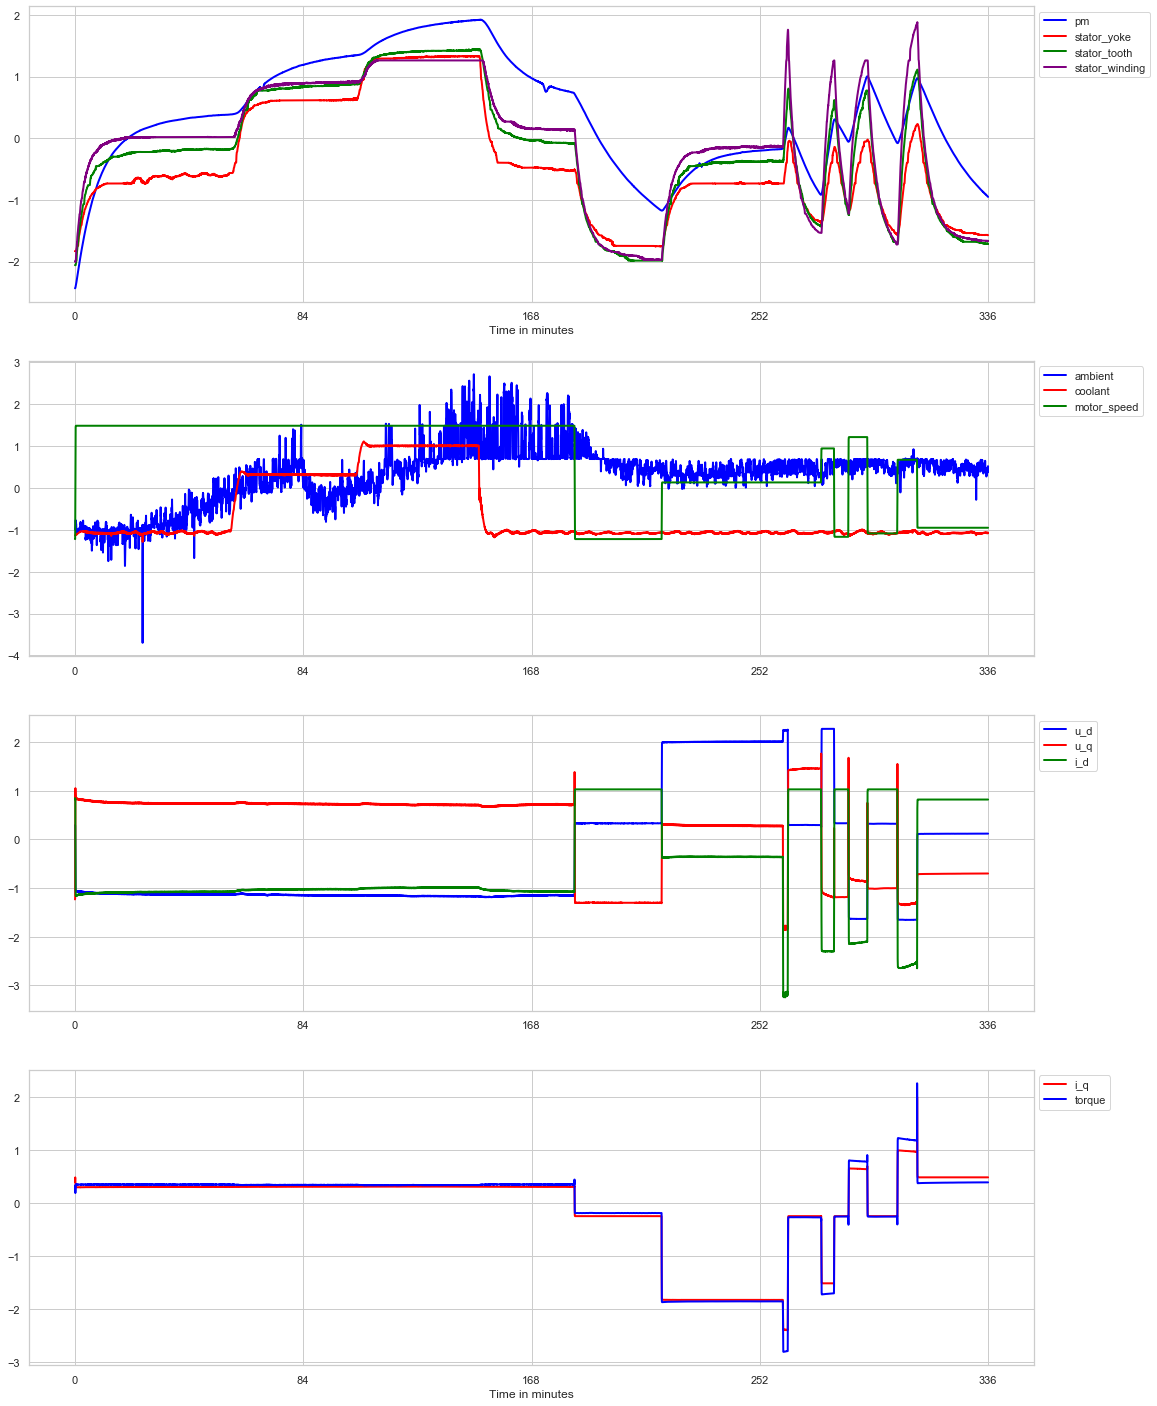

In [183]:
id_session = 6
plot_dfprofile(get_df_profile(grouped_df_id,id_session))

After some explorations on the previous cell we could observe the different profiles simulating real 'walks' for the motor. The lower profiles usually represent less changes on the dynamics of the motor and the higher profiles represent a highly dynamic and stressed motor runs

In [25]:
df2 = get_df_profile(grouped_df_id,47)


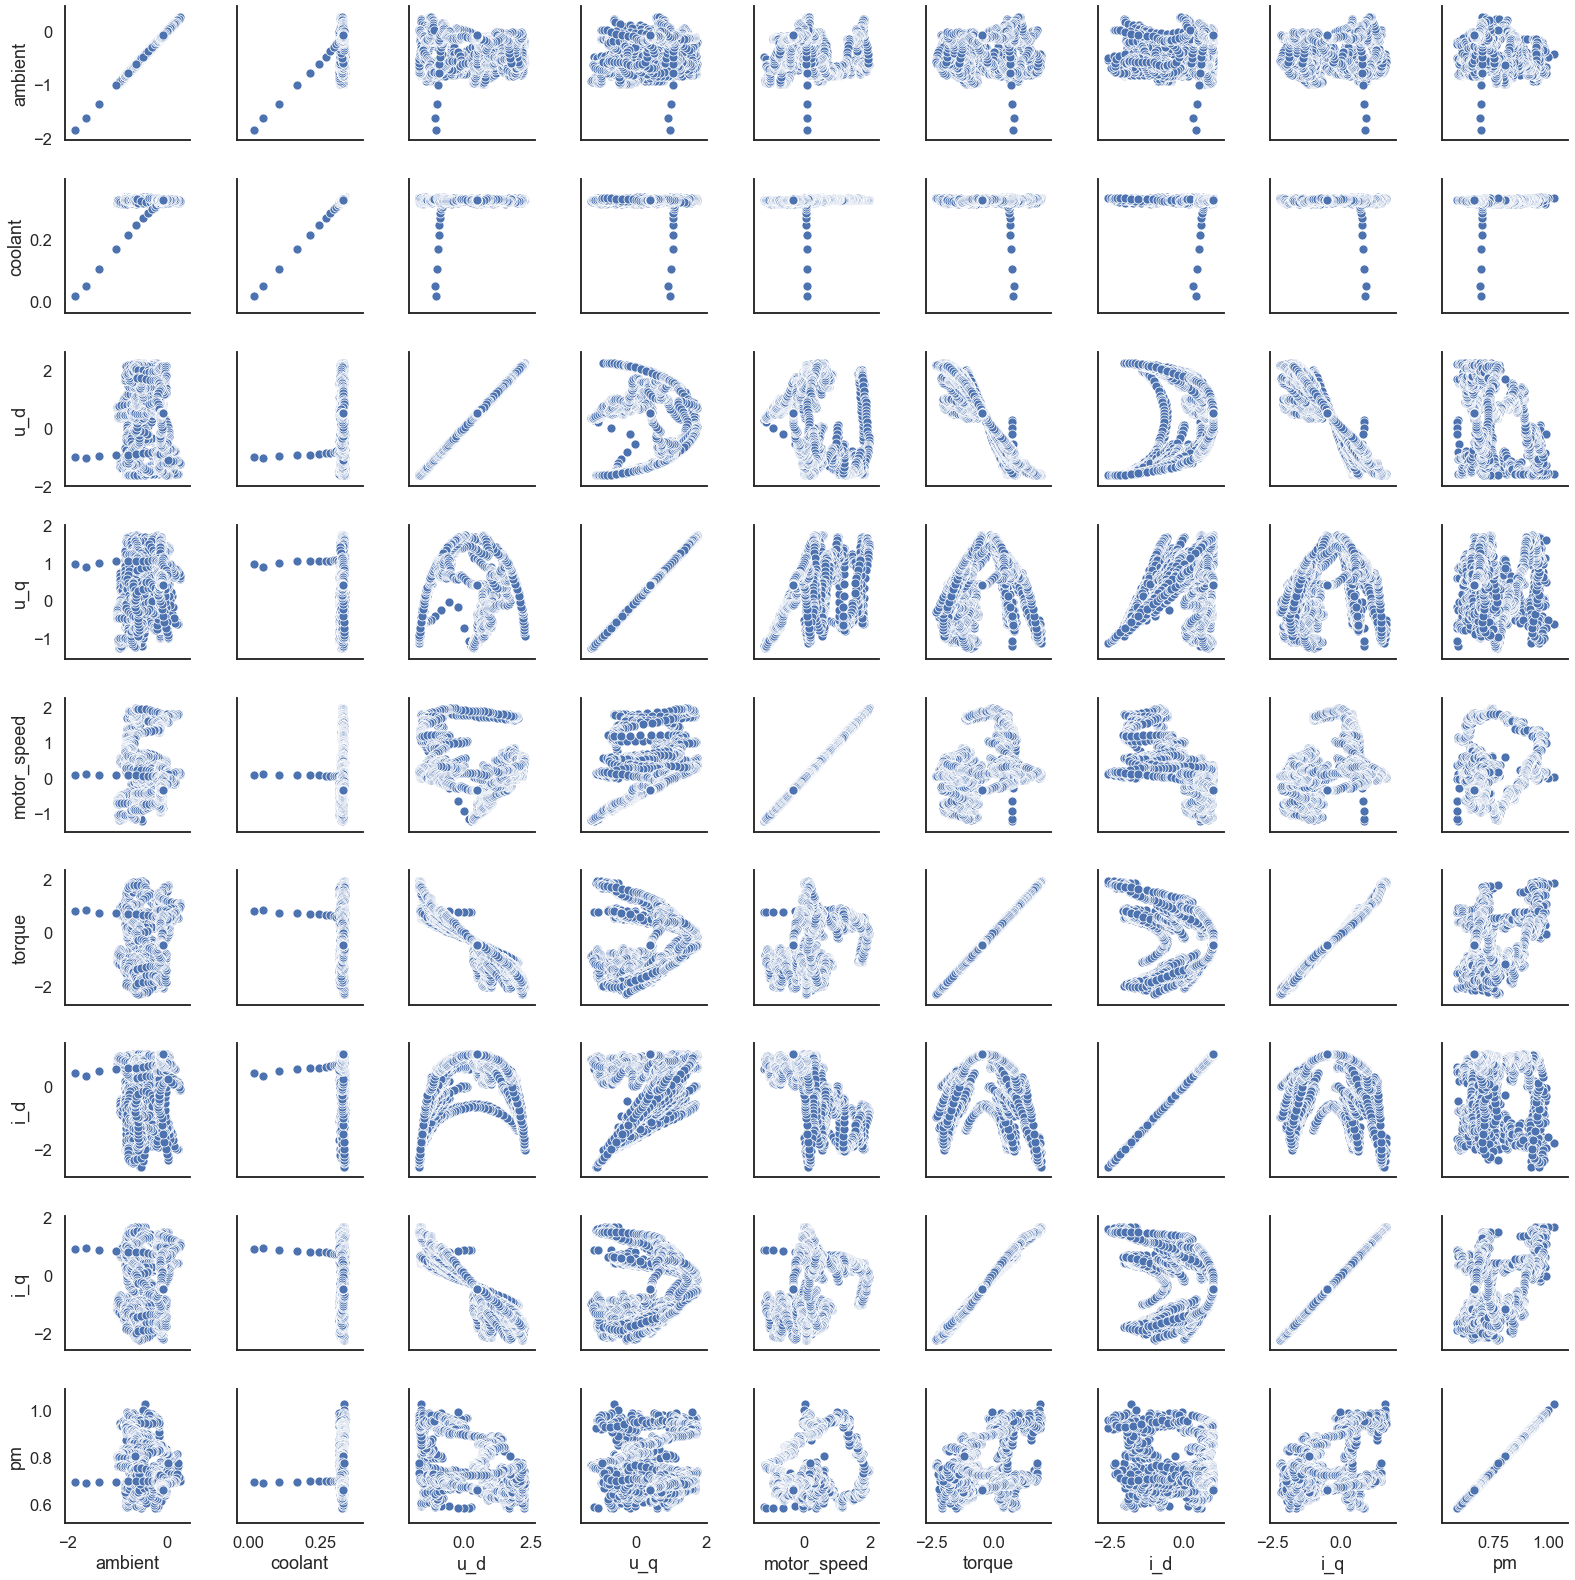

In [276]:
# Data relations on a particular profile
matplotlib.rcParams.update({'font.size': 22})
g = sns.PairGrid(df2.drop(['stator_yoke', 'stator_tooth', 'stator_winding'],axis=1))

g.map(sns.scatterplot)

# Modelling

## Baseline Modeling

The target variable will be the temperature of the permanent magnet: 'pm' the other motor temperatures will be dropped the same as the torque as in not measurable ( or at least feasible) in real motor applications. 

In [26]:
df_new.drop(['torque'],axis =1, inplace = True)
df_new.head()

ambient   coolant       u_d       u_q  motor_speed       i_d       i_q  \
0 -0.752143 -1.118446  0.327935 -1.297858    -1.222428  1.029572 -0.245860   
1 -0.771263 -1.117021  0.329665 -1.297686    -1.222429  1.029509 -0.245832   
2 -0.782892 -1.116681  0.332771 -1.301822    -1.222428  1.029448 -0.245818   
3 -0.780935 -1.116764  0.333700 -1.301852    -1.222430  1.032845 -0.246955   
4 -0.774043 -1.116775  0.335206 -1.303118    -1.222429  1.031807 -0.246610   

         pm  
0 -2.522071  
1 -2.522418  
2 -2.522673  
3 -2.521639  
4 -2.521900

In [27]:
df_new.shape

(998070, 8)

### Split data in train and test datasets

In [28]:
# Target 
y = df_new.loc[:,['pm']]

# Predictors

X = df_new.drop(['pm'], axis = 1)
print('----------------------')
print('X Shape:', X.shape)
print('y Shape:', y.shape)
print('----------------------')

----------------------
X Shape: (998070, 7)
y Shape: (998070, 1)
----------------------


In [29]:
from sklearn.model_selection import train_test_split

In [30]:
# Creating the train, val, and test sets using 20% test 80% to train on

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=19)


In [31]:
# check the shape
print("----------train sets----------")
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print("----------test sets-----------")
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)
print("-----------------------------")

----------train sets----------
X_train Shape: (798456, 7)
y_train Shape: (798456, 1)
----------test sets-----------
X_test Shape: (199614, 7)
y_test Shape: (199614, 1)
-----------------------------


### Train a linear regression model

In [32]:
from sklearn.model_selection import cross_validate

In [277]:
# assign model to variable
regression = LinearRegression(fit_intercept=False)
crossvalidation = KFold(n_splits=5, shuffle=True, random_state= 42)

In [278]:
bas_regression.fit(X_train,y_train)
baseline = cross_validate(regression, X_train, y_train,
                          scoring=('r2','neg_mean_squared_error'),
                          cv = crossvalidation, return_train_score=True)

In [279]:
baseline

{'fit_time': array([0.10895705, 0.08587217, 0.09436965, 0.10296178, 0.10304093]),
 'score_time': array([0.00716686, 0.00569701, 0.00514627, 0.00525117, 0.00508332]),
 'test_r2': array([0.47082977, 0.47290483, 0.47082026, 0.470997  , 0.46856719]),
 'train_r2': array([0.47083571, 0.47031797, 0.47083678, 0.47079402, 0.47139734]),
 'test_neg_mean_squared_error': array([-0.52469808, -0.52190349, -0.527841  , -0.52433799, -0.52427292]),
 'train_neg_mean_squared_error': array([-0.5245786 , -0.52527754, -0.52379409, -0.52466874, -0.52468556])}

In [280]:
# Funtion to print score results from cross_validate scores

def print_scores(scores):
    print('train_r2:',round(scores['train_r2'].mean(),4))
    print('test_r2:',round(scores['test_r2'].mean(),4))
    print('train_MSE: {} (+/- {})'.format(round(-scores['train_neg_mean_squared_error'].mean(),4)
                                          ,round(scores['train_neg_mean_squared_error'].std()*2,4)))
    print('test_MSE: {} (+/- {})'.format(round(-scores['test_neg_mean_squared_error'].mean(),4)
                                          ,round(scores['test_neg_mean_squared_error'].std()*2,4)))


In [281]:
print_scores (baseline) # The results for the baseline model are not too bad although suspiciously identical when rounded

train_r2: 0.4708
test_r2: 0.4708
train_MSE: 0.5246 (+/- 0.0009)
test_MSE: 0.5246 (+/- 0.0038)


In [60]:
regression.coef_

array([[ 0.36784063,  0.30842893, -0.15345226, -0.32380048,  0.53803171,
         0.03962904, -0.05958106]])

## Feature Engineering for second regression model

We can add some features to the initial dataset based on the electrical circuit theory of a PMSM circuit like : Current magnitude (Is), Voltage magnitude (Us) , Aparent power (S) and other iterations with Motor speed. This new colums are based are known magnitudes obtained applying Electric theory. The electric power might be interesting element.The "power disipates as heat on the circuit conductors increasing the temperature.   
<div>.
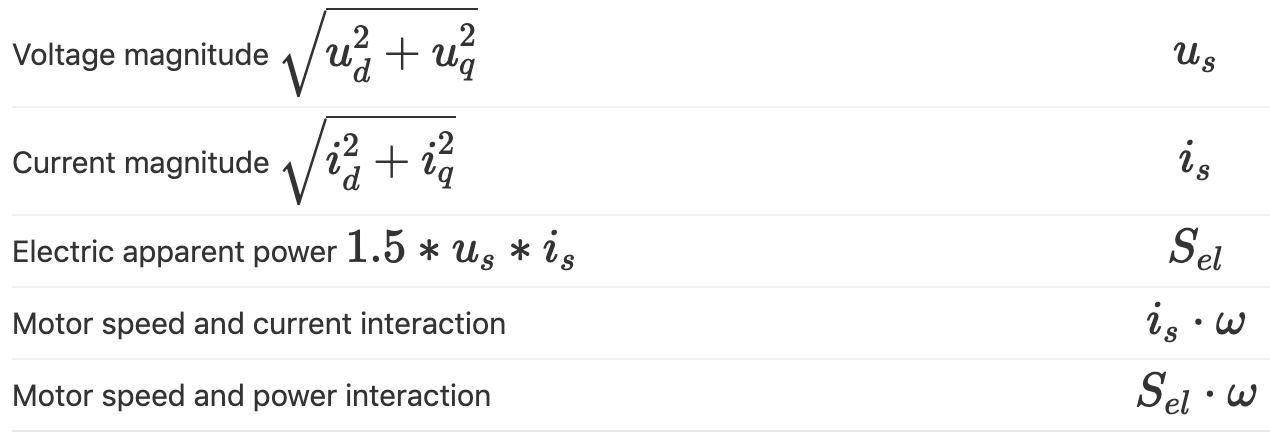
</div>


In [40]:
Derived_features = {
     'i_s': lambda x: np.sqrt(x['i_d']**2 + x['i_q']**2),  # Current vector
     'u_s': lambda x: np.sqrt(x['u_d']**2 + x['u_q']**2),  # Voltage vector
     'S_elec': lambda x: x['i_s']*x['u_s'],                  # Apparent power
     'P_elec': lambda x: x['i_d'] * x['u_d'] + x['i_q'] *x['u_q'],  # Effective power
     'i_s_x_w': lambda x: x['i_s']*x['motor_speed'], 
     'S_x_w': lambda x: x['S_elec']*x['motor_speed'],
}

In [63]:
X_train_xfeat = X_train.copy()
y_train_xfeat = y_train.copy()


In [62]:
X_train_xfeat.assign(**Derived_features)

ambient   coolant       u_d       u_q  motor_speed       i_d  \
216013 -2.733797 -1.075093 -0.346010  0.837716    -0.161887  0.850133   
277343 -2.731002 -1.069825  0.169627  0.394701    -0.410787  1.013967   
642553  0.052745  0.350169  0.275234 -0.946442    -1.065959  0.991983   
685    -0.949429 -1.060085  0.183184  1.680307     2.024116 -0.803674   
349927 -1.297349 -0.339989  0.207295 -0.699013    -0.951884  0.961443   
...          ...       ...       ...       ...          ...       ...   
480168  0.688769  2.180769 -0.138385  1.665656     1.428336 -0.289000   
623970 -0.049758 -0.640850  1.466943  0.246855    -0.241935  0.382274   
82677  -1.297877 -1.067901  0.515279 -0.152752    -0.646166  0.994272   
207470 -2.718124 -1.072506  0.283121 -1.169227    -1.195381  0.820119   
521821  0.681190  0.597834  1.962040  0.358663     1.299289 -1.125160   

             i_q       i_s       u_s    S_elec    P_elec   i_s_x_w     S_x_w  
216013  0.417104  0.946944  0.906361  0.858273  0.055260 -0.153298 -0.138943  
277343 -0.091442  1.018082  0.429607  0.437375  0.135904 -0.418215 -0.179668  
642553 -0.050575  0.993271  0.985651  0.979019  0.320894 -1.058786 -1.043593  
685    -0.255550  0.843326  1.690263  1.425442 -0.576623  1.706989  2.885260  
349927  0.131006  0.970327  0.729102  0.707467  0.107727 -0.923639 -0.673427  
...          ...       ...       ...       ...       ...       ...       ...  
480168 -0.109026  0.308881  1.671395  0.516262 -0.141606  0.441186  0.737396  
623970 -1.709891  1.752101  1.487569  2.606371  0.138680 -0.423894 -0.630571  
82677  -0.617418  1.170377  0.537444  0.629012  0.606639 -0.756258 -0.406446  
207470  0.486920  0.953775  1.203017  1.147407 -0.337127 -1.140125 -1.371589  
521821 -1.099143  1.572928  1.994553  3.137287 -2.601832  2.043688  4.076244  

[798456 rows x 13 columns]

In [85]:
fregression = LinearRegression(fit_intercept=False)
fregression.fit(X_train_xfeat, y_train_xfeat)
liner_xfeat = cross_validate(fregression, X_train_xfeat, y_train_xfeat,
                          scoring=('r2','neg_mean_squared_error'),
                          cv = crossvalidation, return_train_score=True)


In [86]:
liner_xfeat

{'fit_time': array([0.08741903, 0.1085391 , 0.09738922, 0.09695005, 0.10136604]),
 'score_time': array([0.00556111, 0.00562906, 0.00512099, 0.00538707, 0.00471091]),
 'test_r2': array([0.47082977, 0.47290483, 0.47082026, 0.470997  , 0.46856719]),
 'train_r2': array([0.47083571, 0.47031797, 0.47083678, 0.47079402, 0.47139734]),
 'test_neg_mean_squared_error': array([-0.52469808, -0.52190349, -0.527841  , -0.52433799, -0.52427292]),
 'train_neg_mean_squared_error': array([-0.5245786 , -0.52527754, -0.52379409, -0.52466874, -0.52468556])}

In [102]:
# Linear regression with feature engineering
print_scores(liner_xfeat)

train_r2: 0.4708
test_r2: 0.4708
train_MSE: 0.5246 (+/- 0.0009)
test_MSE: 0.5246 (+/- 0.0038)


It seems it has the same results as the previous model. After a few trials I am a bit disapointed as it has no improvement on the scores from baseline model. Something might be wrong.

Let's try a different linear regressor like Random Forest 

## Random Forest Regressor

In [93]:
Rfr = RandomForestRegressor(n_estimators = 20, random_state = 0)
Rfr.fit(X_train,y_train)
RandomFR_model = cross_validate(Rfr, X_train, y_train,
                          scoring=('r2','neg_mean_squared_error'),
                          cv = crossvalidation, return_train_score=True)


In [94]:
RandomFR_model

{'fit_time': array([103.61824417, 104.63851595, 109.39723396, 104.76000094,
        103.92304325]),
 'score_time': array([1.54481673, 1.51712584, 1.593961  , 1.54228401, 1.66857386]),
 'test_r2': array([0.98302116, 0.98287712, 0.98265809, 0.98369169, 0.98284772]),
 'train_r2': array([0.9972069 , 0.99723842, 0.99721758, 0.9972159 , 0.99719055]),
 'test_neg_mean_squared_error': array([-0.01683535, -0.01695423, -0.01729803, -0.0161645 , -0.01692119]),
 'train_neg_mean_squared_error': array([-0.0027689 , -0.00273862, -0.00275418, -0.00276023, -0.00278863])}

In [96]:
# RandomForest regression 
print_scores(RandomFR_model)

     

train_r2: 0.9972
test_r2: 0.983
train_MSE: 0.0028 (+/- 0.0)
test_MSE: 0.0168 (+/- 0.001)



Slight overfit but the results are really good compared with the baseline model.

We will perform a grid search to optimize the hyperparameters for this regressor and fine tune our model


### Grid Search


In [119]:
# Initialize a range of parameters to find the best model

param_grid = {'n_estimators': [3,10,20],'max_features': [2,4,7]}
    
forest_reg = RandomForestRegressor()

gs_forest = GridSearchCV(forest_reg, param_grid, cv=5,scoring= 'neg_mean_squared_error',return_train_score = True)
gs_forest.fit(X_train, y_train)

gs_forest.best_params_
              

{'max_features': 4, 'n_estimators': 20}

In [121]:
gs_forest.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [122]:
cvres = gs_forest.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(round(-mean_score.mean(),4),params)

0.0413 {'max_features': 2, 'n_estimators': 3}
0.0266 {'max_features': 2, 'n_estimators': 10}
0.0237 {'max_features': 2, 'n_estimators': 20}
0.0255 {'max_features': 4, 'n_estimators': 3}
0.0172 {'max_features': 4, 'n_estimators': 10}
0.0155 {'max_features': 4, 'n_estimators': 20}
0.0243 {'max_features': 7, 'n_estimators': 3}
0.0182 {'max_features': 7, 'n_estimators': 10}
0.0168 {'max_features': 7, 'n_estimators': 20}


Grid search has found the best model  MSE = 0.155 which is better than what we previously obtained MSE = O.168


In [123]:
# We extract feature importances and then visualize them

feature_importances = gs_forest.best_estimator_.feature_importances_
feature_importances 

array([0.23851177, 0.28541853, 0.12073585, 0.08790115, 0.13883139,
       0.06868541, 0.05991591])

In [256]:
df_feat = pd.DataFrame(feature_importances,index = X_train.columns,columns = ["Importances"])
df_feat['Features'] = df_feat.index
df_feat.reset_index(drop=True, inplace=True)
df_feat.sort_values(by=['Importances'] ,ascending= False, inplace = True)
df_feat

Importances     Features
1     0.285419      coolant
0     0.238512      ambient
4     0.138831  motor_speed
2     0.120736          u_d
3     0.087901          u_q
5     0.068685          i_d
6     0.059916          i_q

The most relevant feature are  "coolant" and ambient temperature 

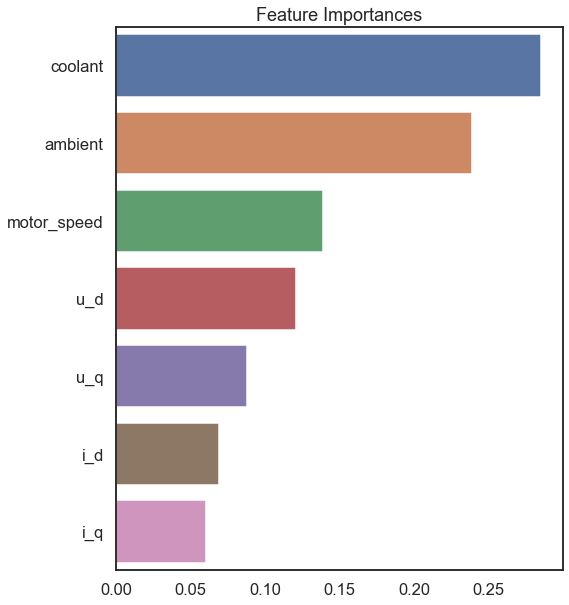

In [274]:
 fig, axes = plt.subplots(figsize=(8,10))
sns.set_context("talk")
sns.barplot(y='Features', x='Importances', data=df_feat).set_title('Feature Importances')
axes.set_xlabel('')
axes.set_ylabel('')
plt.savefig('./figures/Feature Importances.png')  

## Best model selection

In [150]:
# From the gridsearch we can directly save the best model 

final_model = gs_forest.best_estimator_

## Testing best model

In [159]:

# Final model selected then we obtain the predicted values to test against the test data we have saved from out dataset

final_predictions = final_model.predict(X_test)# Obtain predicted values from final best model

In [167]:
final_mse = mean_squared_error(y_test,final_predictions)
final_mse

0.013361251762329635

The test MSE score is even better than the one obtained from the train data of the best model which was MSE = 0.0155

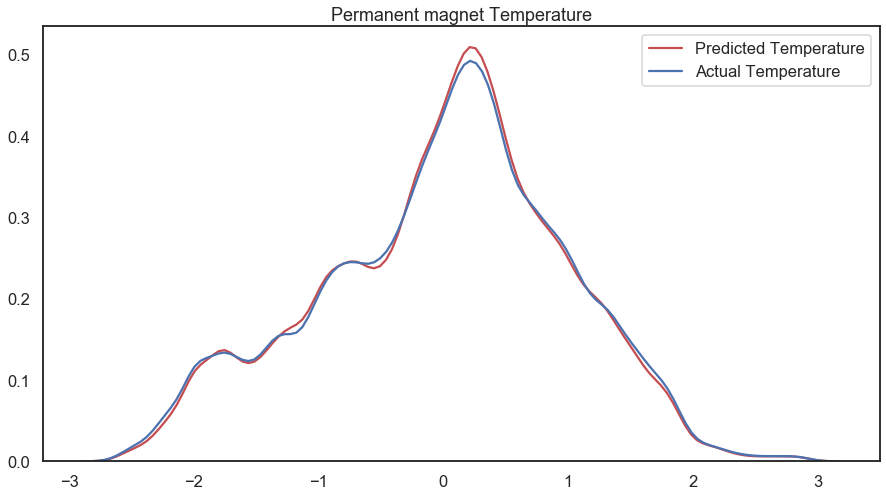

In [275]:
# Visualizing the results obtained predicted vs test data

import seaborn as sns

plt.figure(figsize=(15,8))
sns.set_context("talk")
sns.set_style("white")
ax1 = sns.distplot(final_predictions, hist=False, color="r", label="Predicted Temperature")
sns.distplot(y_test, hist=False, color="b", label="Actual Temperature" , ax=ax1)
ax1.set_title('Permanent magnet Temperature')
plt.savefig('./figures/Final model predictions.png')


Plotting both sets we can observed the predicted data and actual data which  are very close. Our model has a good performance

### Save Model

In [3]:
# Save the model as a pickle in a file, file too large, skip step at this stage   
#pickle.dump(final_model, 'Randomforest_temp.pkl') 

## Future improvements

- Introduce a pipeline to obtain data from testbech data acquisition
- Review model with feature engineering
- Explore other machine learning models to improve performance